In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, confusion_matrix


# Load your processed audit logs CSV with features
df = pd.read_csv("../data/logs/simulated_audit_logs_with_features.csv", parse_dates=["timestamp"])
df.head()

,timestamp,user,ip_address,event_type,resource,random_token,label,event_hour,day_of_week,event_type_code,resource_depth,is_privileged_event,is_weekend,failed_logins_last_1h,ip_event_count,user_event_rate
0,2025-06-29 15:44:02.653200,user_18,7.70.82.26,login_failure,tag/app,5c47fd7159274ba98b7f0712cd718d8ff0f01349,0,15,6,0,1,0,True,0,1,20.933333
1,2025-06-29 15:46:47.628249,user_23,137.222.136.223,file_access,tags/explore/tag,64610b4723e238866b03a57b32b5e251b1697adb,0,15,6,3,2,0,True,0,1,20.066667
2,2025-06-29 15:57:23.210818,bad_actor_2,209.21.69.59,login_failure,blog/categories,2b884528883f44bdc9064c741f8a268b3a2514ea,1,15,6,0,1,0,True,0,1,13.800000
3,2025-06-29 15:58:04.898027,user_23,190.135.208.166,login_success,categories/blog/list,736588be1702a6281f54e6cda5eaddfe73cf16db,1,15,6,1,2,0,True,0,1,20.066667
4,2025-06-29 16:02:36.460715,user_21,144.46.83.88,file_access,tag,2fd5b2c268c272a3339122b2a168a7954a2b01c0,0,16,6,3,0,0,True,0,1,20.000000


In [2]:
# Define features and target
features = [
    "event_hour", "event_type_code", "resource_depth",
    "is_privileged_event", "is_weekend",
    "failed_logins_last_1h", "ip_event_count", "user_event_rate"
]

X = df[features]
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
print(np.unique(y_train, return_counts=True)), print(np.unique(y_test, return_counts=True))


(array([0, 1]), array([6533, 1467]))
(array([0, 1]), array([1633,  367]))


(None, None)

In [4]:
import mlflow
import mlflow.xgboost

with mlflow.start_run(run_name="xgboost_anomaly_detection"):

    # Log hyperparameters
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)

    # Train model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        base_score =0.5,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Precision", precision)

    # Log the model
    mlflow.xgboost.log_model(model, artifact_path="model")

    print(f"AUC: {auc:.4f}")
    print(f"Precision: {precision:.4f}")


/Users/kous21/Desktop/GitHubFiles/autoriskAI/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/07/14 15:48:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Users/kous21/Desktop/GitHubFiles/autoriskAI/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [15:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/07/14 15:48:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


AUC: 0.7613
Precision: 0.9050


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1612   21]
 [ 167  200]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.94      1633
           1       0.90      0.54      0.68       367

    accuracy                           0.91      2000
   macro avg       0.91      0.77      0.81      2000
weighted avg       0.91      0.91      0.90      2000



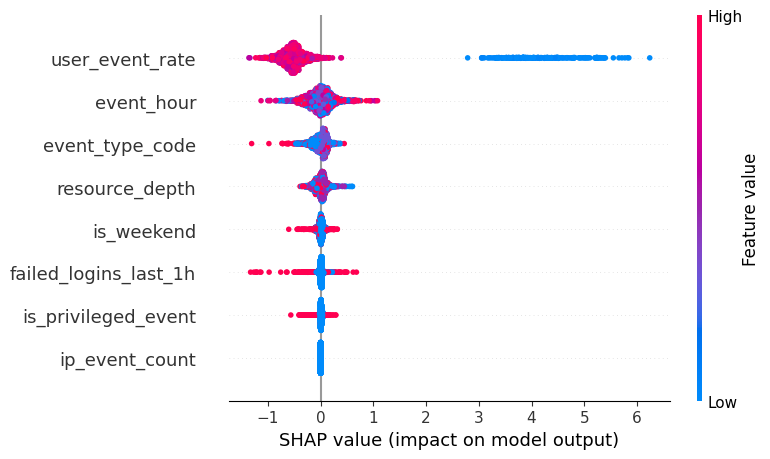

In [6]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


In [7]:
import mlflow
import mlflow.xgboost
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
import xgboost as xgb

# Assuming X, y are your features and labels (preprocessed)

# Setup cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []
avg_precisions = []

with mlflow.start_run(run_name="xgboost_cv_with_pr_curve"):

    fold = 1
    for train_index, val_index in skf.split(X, y):
        print(f"Fold {fold} training...")

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            use_label_encoder=False,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        )

        model.fit(X_train, y_train)

        y_val_probs = model.predict_proba(X_val)[:, 1]
        y_val_pred = model.predict(X_val)

        # Metrics
        auc = roc_auc_score(y_val, y_val_probs)
        avg_precision = average_precision_score(y_val, y_val_probs)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)

        print(f"Fold {fold} - AUC: {auc:.4f}, Avg Precision: {avg_precision:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        # Log per-fold metrics
        mlflow.log_metric(f"fold{fold}_auc", auc)
        mlflow.log_metric(f"fold{fold}_avg_precision", avg_precision)
        mlflow.log_metric(f"fold{fold}_precision", precision)
        mlflow.log_metric(f"fold{fold}_recall", recall)
        mlflow.log_metric(f"fold{fold}_f1", f1)

        auc_scores.append(auc)
        avg_precisions.append(avg_precision)

        # Plot and log Precision-Recall curve as artifact per fold
        precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_val_probs)
        plt.figure()
        plt.plot(recall_vals, precision_vals, label=f'Fold {fold} AP={avg_precision:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - Fold {fold}')
        plt.legend()
        plt.grid(True)

        pr_curve_path = f"pr_curve_fold_{fold}.png"
        plt.savefig(pr_curve_path)
        plt.close()

        mlflow.log_artifact(pr_curve_path)

        fold += 1

    # Log aggregated metrics
    mlflow.log_metric("mean_auc", np.mean(auc_scores))
    mlflow.log_metric("std_auc", np.std(auc_scores))
    mlflow.log_metric("mean_avg_precision", np.mean(avg_precisions))
    mlflow.log_metric("std_avg_precision", np.std(avg_precisions))

    print(f"Mean AUC over folds: {np.mean(auc_scores):.4f}")
    print(f"Mean Average Precision over folds: {np.mean(avg_precisions):.4f}")


Fold 1 training...
Fold 1 - AUC: 0.7625, Avg Precision: 0.6225, Precision: 0.9104, Recall: 0.5273, F1: 0.6678
Fold 2 training...


/Users/kous21/Desktop/GitHubFiles/autoriskAI/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kous21/Desktop/GitHubFiles/autoriskAI/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 - AUC: 0.7373, Avg Precision: 0.6035, Precision: 0.8818, Recall: 0.4877, F1: 0.6281
Fold 3 training...
Fold 3 - AUC: 0.7558, Avg Precision: 0.6234, Precision: 0.8962, Recall: 0.5177, F1: 0.6563


/Users/kous21/Desktop/GitHubFiles/autoriskAI/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kous21/Desktop/GitHubFiles/autoriskAI/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 training...
Fold 4 - AUC: 0.7427, Avg Precision: 0.6220, Precision: 0.8905, Recall: 0.5095, F1: 0.6482
Fold 5 training...
Fold 5 - AUC: 0.7494, Avg Precision: 0.6131, Precision: 0.8796, Recall: 0.5177, F1: 0.6518
Mean AUC over folds: 0.7495
Mean Average Precision over folds: 0.6169


/Users/kous21/Desktop/GitHubFiles/autoriskAI/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
